In [1]:
import sys
import os
os.environ['CUDA_HOME'] = '/usr/local/cuda-9.0'
sys.path.insert(0, 'research/vardl-dev')

import vardl
import matplotlib
import torch
import torch.optim
import matplotlib.pyplot as plt
import numpy as np

logger = vardl.utils.setup_logger('vardl', '/tmp/')
device='cuda'

research/vardl-dev/vardl/functional/fwht/__init__.py:28: UserWarning: Including and compiling a custom C++ and CUDA (if available) extension might take a while...
  warnings.warn('Including and compiling a custom C++ and CUDA (if available) extension might take a while...', )
research/vardl-dev/vardl/functional/fwht/__init__.py:31: UserWarning: CXX variable not set. Setting CXX=g++...
  warnings.warn('CXX variable not set. Setting CXX=g++...',)
research/vardl-dev/vardl/functional/fwht/__init__.py:36: UserWarning: PATH variable does not include ~/.local/bin. Updating PATH=$HOME/.local/bin:$PATH
  warnings.warn('PATH variable does not include ~/.local/bin. Updating PATH=$HOME/.local/bin:$PATH')


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


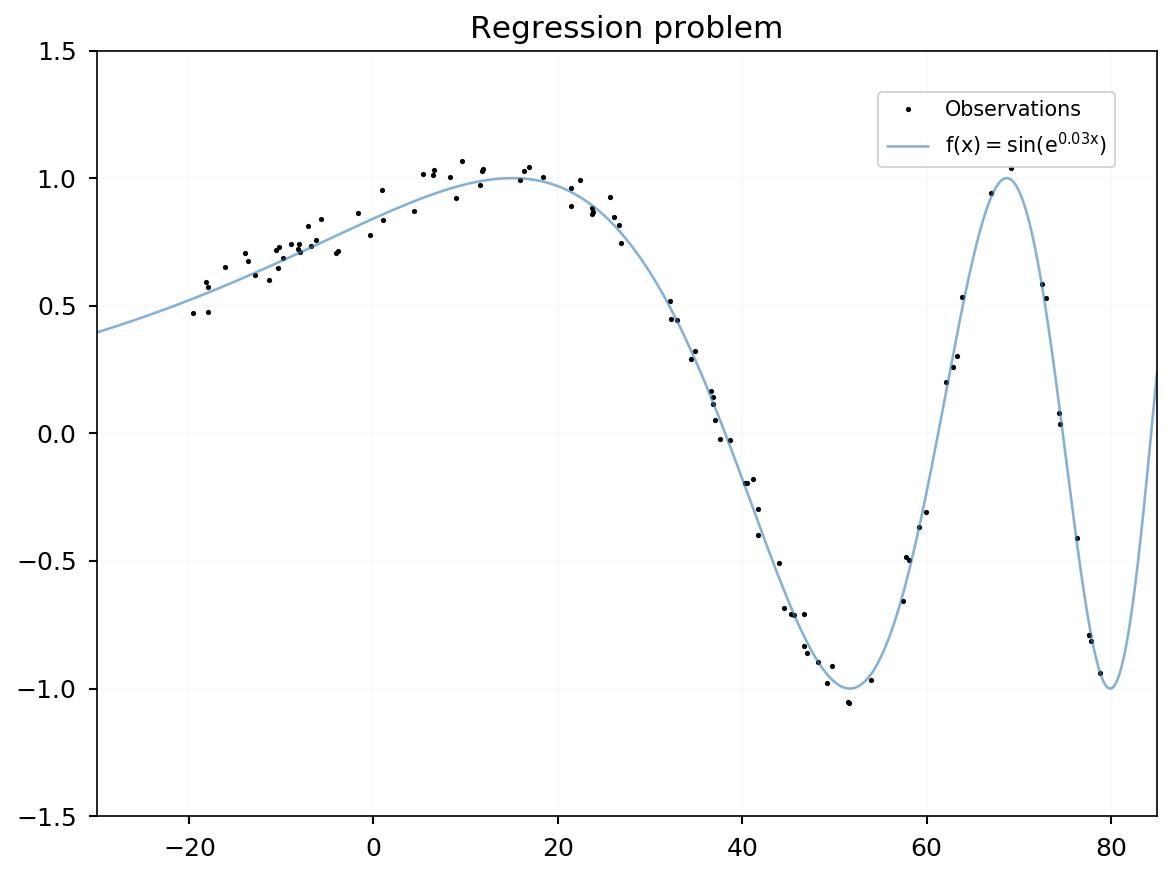

In [2]:
matplotlib.rc_file('~/.config/matplotlib/matplotlibrc')
vardl.utils.set_seed(0)
n=100
# Define our function
f = lambda x: np.sin(np.exp(.03 * x)) 
# Define our observation points
x = np.sort(np.random.uniform(-20,80,n))
# Define our target points
y = f(x)+ np.exp(-3) * np.random.randn(len(x))

# Plot 
fig, ax = plt.subplots()
ax.plot(x, y, '.', c='black', label='Observations')
ax.plot(np.linspace(-30, 85, 1000), f(np.linspace(-30, 85, 1000)), alpha=0.6, label=r"$f({x}) = sin(e^{0.03 {x}})$" )
ax.set_title("Regression problem")
ax.set_ylim(-1.5, 1.5)
ax.legend()
plt.show()

In [45]:
vardl.utils.set_seed(0)
gp = vardl.layers.VariationalGaussianProcessRFF(1, 1, 128, 'rbf', False, 
                                                learn_Omega='prior_fixed', 
                                                learn_theta='var', add_mean=0)
gp = gp.to(device)
print(gp)

likelihood = vardl.likelihoods.Gaussian()
likelihood = likelihood.to(device)
likelihood.log_noise_var.data.fill_(-4)

params = set(filter(lambda p: p.requires_grad, gp.parameters()))#.union(set(likelihood.parameters()))
optim = torch.optim.RMSprop(params, lr=0.001)

VariationalGaussianProcessRFF(
  (prior_log_theta_sigma2): FullyFactorizedMultivariateGaussian(n=1)
  (posterior_log_theta_sigma2): FullyFactorizedMultivariateGaussian(n=1)
  (prior_log_theta_lenghtscale): FullyFactorizedMultivariateGaussian(n=1)
  (posterior_log_theta_lenghtscale): FullyFactorizedMultivariateGaussian(n=1)
  (prior_Omega): FullyFactorizedMatrixGaussian(n=1, m=128)
  (prior_weights): FullyFactorizedMatrixGaussian(n=256, m=1)
  (posterior_weights): FullyFactorizedMatrixGaussian(n=256, m=1)
)


In [46]:
vardl.utils.set_seed(0)
x_train = torch.tensor(x).float().view(-1, 1) * torch.ones(128, 1, 1)
y_train = torch.tensor(y).float().view(-1, 1) 

x_train = x_train.to(device)
y_train = y_train.to(device)


for _ in range(7500):
    optim.zero_grad()
    y_pred = gp(x_train)
    nell = -torch.sum(torch.mean(likelihood.log_cond_prob(y_train, y_pred), 0))
    kl = gp.kl_divergence()
    loss = nell + kl
    loss.backward()
    optim.step()
print(loss)

tensor(85.7472, device='cuda:0', grad_fn=<ThAddBackward>)


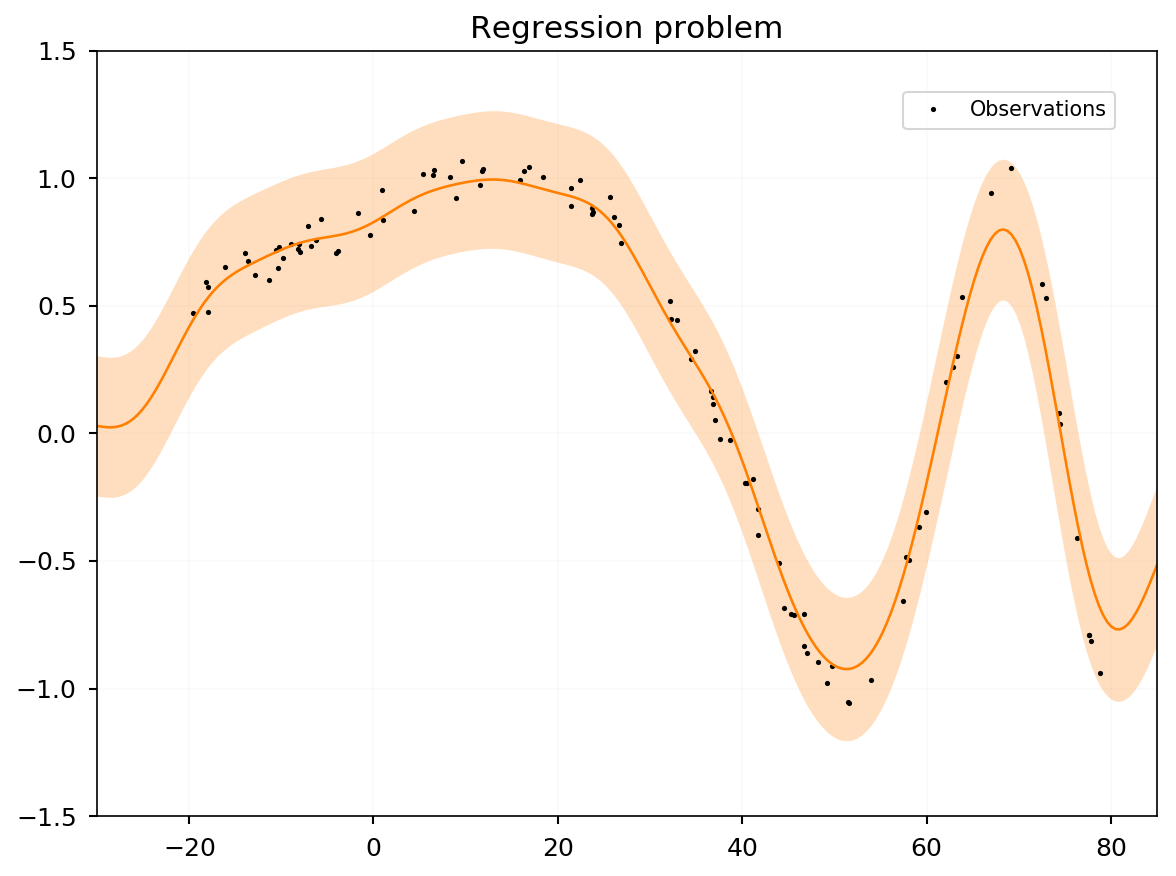

In [47]:
fig, ax = plt.subplots()
x_test = np.linspace(-30, 85, 256) 

y_pred_mean, y_pred_ub, y_pred_lb = likelihood.predict(
    gp((torch.tensor(x_test).view(-1, 1).float() * torch.ones(128, 1, 1)).to(device)), 0.2)
ax.plot(x, y, '.', c='black', label='Observations')

color = '#ff7f00'
ax.plot(x_test, y_pred_mean, color=color)
ax.fill_between(x_test, y_pred_lb.reshape(-1), y_pred_ub.reshape(-1), color=color, alpha=0.25, linewidth=0)
ax.set_title("Regression problem")
ax.set_ylim(-1.5, 1.5)
ax.legend()
plt.show()
